# Explore Exercises

These exercises should go in a notebook or script named explore.

Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

1. How many different cases are there, by department?
2. Does the percentage of cases that are late vary by department?
3. On average, how late are the late cases by department?
4. What is the service type that is the most late? Just for Parks & Rec?
5. For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.
6. Does whether or not its a weekend matter for when a case is opened/closed?
7. On average, how many cases are opened a day for the Customer Service department?
8. Does the number of service requests for the solid waste department vary by day of the week?

In [1]:
# import needed libraries
import warnings
warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)


[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                

In [2]:
# create spark session
spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                

1. How many different cases are there, by department?

In [25]:
(
    df.groupby('department')
    .count()
    .show()
)


+--------------------+------+
|          department| count|
+--------------------+------+
|         Solid Waste|279270|
|Animal Care Services|116915|
|Trans & Cap Impro...| 96193|
|  Parks & Recreation| 19907|
|    Customer Service|  2849|
|        Metro Health|  5163|
|        City Council|    33|
|DSD/Code Enforcement|321374|
+--------------------+------+



Text(0.5, 0, 'count')

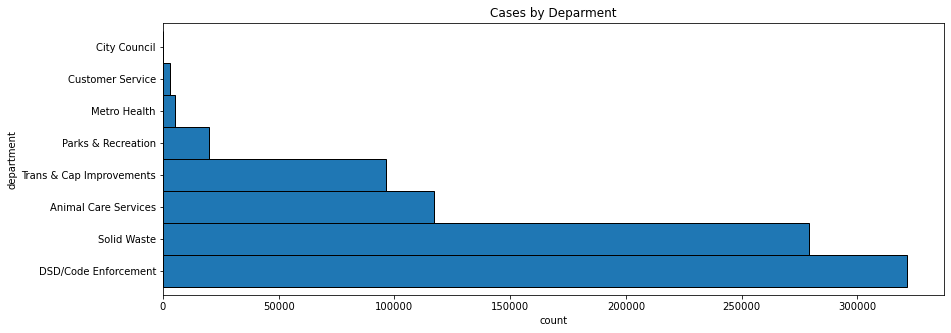

In [32]:
(
    df.groupby('department')
    .count()
    .toPandas()
    .set_index('department')['count']
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor='black', figsize=(14,5))
)
plt.title('Cases by Deparment')
plt.ylabel('department')
plt.xlabel('count')

2. Does the percentage of cases that are late vary by department?

In [22]:
# by department, percentage of late cases ( cases / n_cases)

(
    df.filter(df.case_late == True)
    .groupby('department')
    .count()
    .withColumn('percent', round(((col('count') / df.count())*100),2))
    .show()
)

+--------------------+-----+-------+
|          department|count|percent|
+--------------------+-----+-------+
|         Solid Waste|32945|   3.91|
|Animal Care Services|23276|   2.77|
|Trans & Cap Impro...| 5411|   0.64|
|  Parks & Recreation| 3797|   0.45|
|    Customer Service| 2010|   0.24|
|        Metro Health|  829|    0.1|
|DSD/Code Enforcement|26235|   3.12|
+--------------------+-----+-------+



Text(0.5, 0, 'percent')

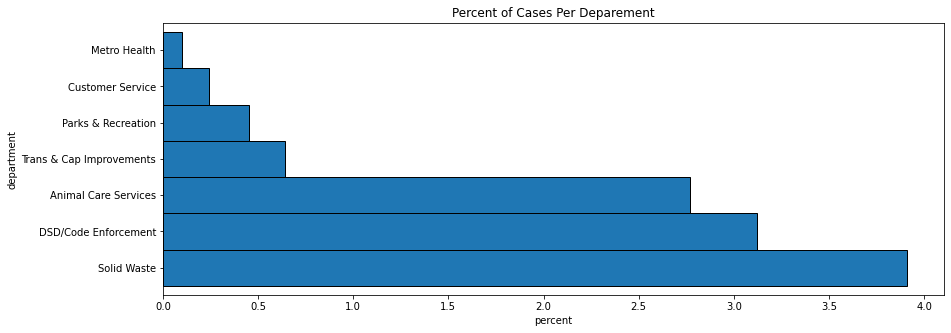

In [40]:
# by department, percentage of late cases ( cases / n_cases)

(
    df.filter(df.case_late == True)
    .groupby('department')
    .count()
    .withColumn('percent', round(((col('count') / df.count())*100),2))
    .toPandas()
    .set_index('department')['percent']
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor='black', figsize=(14,5))
)
plt.title('Percent of Cases Per Deparement')
plt.ylabel('department')
plt.xlabel('percent')

3. On average, how late are the late cases by department?

In [43]:
df.show(1, False, True)

-RECORD 0----------------------------------------------------
 case_id              | 1014127332                           
 case_opened_date     | 2018-01-01 00:42:00                  
 case_closed_date     | 2018-01-01 12:29:00                  
 case_due_date        | 2020-09-26 00:42:00                  
 case_late            | false                                
 num_days_late        | -998.5087616000001                   
 case_closed          | true                                 
 service_request_type | Stray Animal                         
 SLA_days             | 999.0                                
 case_status          | Closed                               
 source_id            | svcCRMLS                             
 request_address      | 2315  EL PASO ST, San Antonio, 78207 
 council_district     | 005                                  
 num_weeks_late       | -142.6441088                         
 zipcode              | 78207                                
 case_ag

In [62]:
# subgroup for late cases, make column of diff for late cases
(
    df.filter(df.case_late == True)
    .withColumn('days_late', datediff(current_timestamp(), df.case_due_date))
    .groupby('department')
    .agg(round(mean('days_late')).cast('int').alias('avg_days_late'))
    .show()
)

+--------------------+-------------+
|          department|avg_days_late|
+--------------------+-------------+
|         Solid Waste|         1583|
|Animal Care Services|         1568|
|Trans & Cap Impro...|         1564|
|  Parks & Recreation|         1589|
|    Customer Service|         1574|
|        Metro Health|         1476|
|DSD/Code Enforcement|         1569|
+--------------------+-------------+



Text(0.5, 0, 'average days')

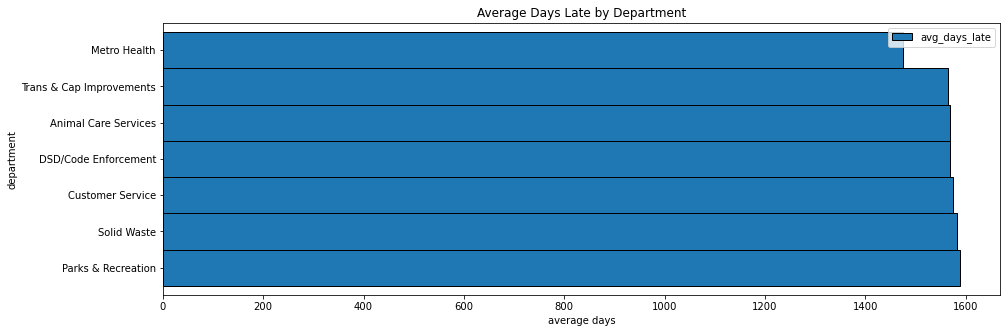

In [88]:
# subgroup for late cases, make column of diff for late cases
(
    df.filter(df.case_late == True)
    .withColumn('days_late', datediff(current_timestamp(), df.case_due_date))
    .groupby('department')
    .agg(round(mean('days_late')).cast('int').alias('avg_days_late'))
    .toPandas()
    .set_index('department')
    .sort_values(by='avg_days_late', ascending=False)
    .plot.barh(width=1, edgecolor='black', figsize=(15,5))
)
plt.title('Average Days Late by Department')
plt.ylabel('department')
plt.xlabel('average days')

4. What is the service type that is the most late? Just for Parks & Rec?

Text(0.5, 0, 'Average Days Late')

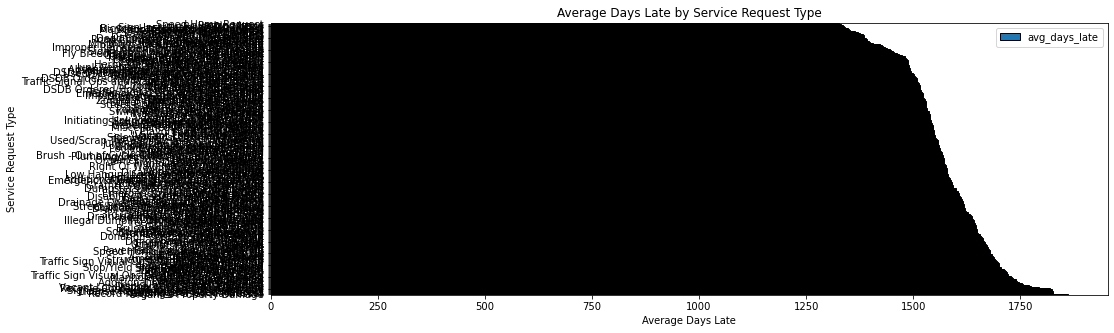

In [89]:
# subgroup for late cases, make column of diff for late cases, groupby by service type, select top 5
(
    df.filter(df.case_late == True)
    .withColumn('days_late', datediff(current_timestamp(), df.case_due_date))
    .groupby('service_request_type')
    .agg(round(mean('days_late')).cast('int').alias('avg_days_late'))
    .toPandas()
    .set_index('service_request_type')
    .sort_values(by='avg_days_late', ascending=False)
    .plot.barh(width=1, edgecolor='black', figsize=(15,5))
)
plt.title('Average Days Late by Service Request Type')
plt.ylabel('Service Request Type')
plt.xlabel('Average Days Late')

5. For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

6. Does whether or not its a weekend matter for when a case is opened/closed?

7. On average, how many cases are opened a day for the Customer Service department?

8. Does the number of service requests for the solid waste department vary by day of the week?